# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [5]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

C:\Users\sujpanda\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [101]:
# using SQLite Table to read data.
con = sqlite3.connect('C:\\Users\\sujpanda\\Desktop\\applied\\database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 100000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (100000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [102]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [103]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [104]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [105]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [106]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [107]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [108]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(87775, 10)

In [109]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

87.775

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [110]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [111]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [112]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(87773, 10)


1    73592
0    14181
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [113]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [114]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [115]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
The Candy Blocks were a nice visual for the Lego Birthday party but the candy has little taste to it.  Very little of the 2 lbs that I bought were eaten and I threw the rest away.  I would not buy the candy again.
was way to hot for my blood, took a bite and did a jig  lol
My dog LOVES these treats. They tend to have a very strong fish oil smell. So if you are afraid of the fishy smell, don't get it. But I think my dog likes it because of the smell. These treats are really small in size. They are great for training. You can give your dog several of these without worrying about him over eating. Amazon's price was much more reasonable than any other retailer. You can buy a

In [116]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [117]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

was way to hot for my blood, took a bite and did a jig  lol


In [118]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [119]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

was way to hot for my blood took a bite and did a jig lol


In [120]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [121]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 87773/87773 [01:18<00:00, 1111.85it/s]


In [122]:
preprocessed_reviews[1500]

'way hot blood took bite jig lol'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [123]:
from tqdm import tqdm
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|██████████| 87773/87773 [01:01<00:00, 1434.16it/s]


In [124]:
print(preprocessed_summary[1000])

not much taste


# [5] Assignment 4: Apply Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using absolute values of `coef_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

In [125]:
## Some utility functions

def get_optimum_alpha(X_train,X_test,y_train,y_test):
    
    from sklearn.metrics import roc_curve
    from sklearn.metrics import roc_auc_score
    
    alphas_range1 = ['0.000001','0.00001','0.0001','0.001','0.01','0.1','10','100','1000','10000','100000']
    alphas_range = [0.000001,0.00001,0.0001,0.00,0.01,0.1,10,100,1000,10000,100000]
    dummy_range = [1,2,3,4,5,6,7,8,9,10,11]

    auc_scores =[]
    auc_train_scores = []

    i = 0
    for i in alphas_range:
        clf = MultinomialNB(alpha=i)

        # fitting the model on crossvalidation train
        clf.fit(X_train, y_train)

        
        #evaluate AUC score.
        probs = clf.predict_proba(X_test)
        probs = probs[:, 1]
        # calculate AUC
        auc = roc_auc_score(y_test, probs)
        print('AUC: %.3f' % auc)
        auc_scores.append(auc)
   
    print('#######################################################')
    print('AUC from train data ###################################')
    i = 0
    for i in alphas_range:
        clf = MultinomialNB(i)

        # fitting the model on crossvalidation train
        clf.fit(X_train, y_train)
        
        #evaluate AUC score.
        probs = clf.predict_proba(X_train)
        probs = probs[:, 1]
        # calculate AUC
        auc = roc_auc_score(y_train, probs)
        print('AUC: %.3f' % auc)
        auc_train_scores.append(auc) 

    plt.plot(dummy_range, auc_scores,'r')
    plt.plot(dummy_range, auc_train_scores,'b')
    plt.xticks(dummy_range, alphas_range1, rotation='vertical')
    for xy in zip(dummy_range, auc_scores):
        plt.annotate('(%f, %f)' % xy, xy=xy, textcoords='data')
    for xy in zip(dummy_range, auc_train_scores):
        plt.annotate('(%f, %f)' % xy, xy=xy, textcoords='data')


    plt.xlabel('Alphas')
    plt.ylabel('auc_scores')
    plt.show()


In [126]:
def nb_results(optimum_alpha,X_train,X_test,y_train,y_test):
    # roc curve and auc
    from sklearn.datasets import make_classification
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import roc_curve
    from sklearn.metrics import roc_auc_score
    from matplotlib import pyplot
    # ============================== KNN with k = optimal_k ===============================================
    # instantiate learning model with optimum alpha
    clf = MultinomialNB(alpha=optimum_alpha)

    # fitting the model
    clf.fit(X_train, y_train)

    # predict the response
    pred = clf.predict(X_test)

    # evaluate accuracy
    acc = accuracy_score(y_test, pred) * 100
    print('\nThe accuracy of the NB classifier for alpha = %f is %f%%' % (optimum_alpha, acc))

    probs = clf.predict_proba(X_test)
    probs = probs[:, 1]
    # calculate AUC
    auc = roc_auc_score(y_test, probs)
    print('AUC: %.3f' % auc)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    # plot no skill
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    pyplot.plot(fpr, tpr, marker='.')
    # show the plot
    pyplot.show()
    from sklearn.metrics import confusion_matrix
    con_mat = confusion_matrix(y_test, pred, [0, 1])
    return con_mat

In [127]:
def showHeatMap(con_mat):
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(con_mat, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

In [128]:
def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=10):
    labelid = list(classifier.classes_).index(classlabel)
    feature_names = vectorizer.get_feature_names()
    topn = sorted(zip(classifier.coef_[labelid], feature_names))[-n:]

    for coef, feat in topn:
        print(classlabel, feat, coef)

# Applying Multinomial Naive Bayes

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [129]:
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
import warnings
warnings.filterwarnings("ignore")

In [130]:
print(final['Text'].shape)

(87773,)


In [131]:
X_1, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)


AUC: 0.783
AUC: 0.802
AUC: 0.826
AUC: 0.741
AUC: 0.884
AUC: 0.907
AUC: 0.697
AUC: 0.548
AUC: 0.517
AUC: 0.477
AUC: 0.443
#######################################################
AUC from train data ###################################
AUC: 0.984
AUC: 0.983
AUC: 0.983
AUC: 0.984
AUC: 0.979
AUC: 0.972
AUC: 0.719
AUC: 0.553
AUC: 0.518
AUC: 0.478
AUC: 0.444


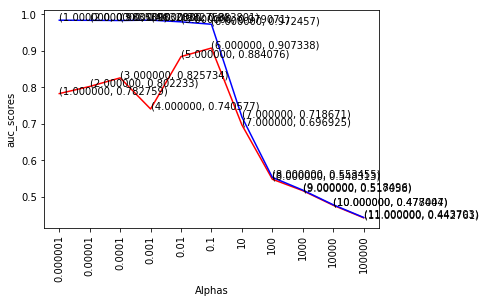

In [132]:
count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(X_1)
final_test_count = count_vect.transform(X_test)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

final_counts_tr_cv = count_vect.transform(X_tr)
final_test_count_cv = count_vect.transform(X_cv)

get_optimum_alpha(final_counts_tr_cv,final_test_count_cv,y_tr,y_cv)


The accuracy of the NB classifier for alpha = 10.000000 is 84.805560%
AUC: 0.738


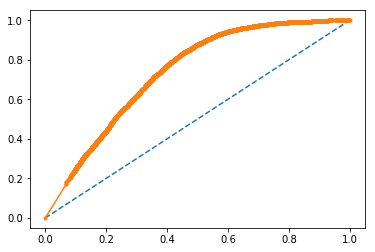

In [133]:
con_mat=nb_results(10,final_counts,final_test_count,y_1,y_test)

Observation : With alpha = 10 the accuracy is 86 % and AUC is 0.738 which is much better than dumb model.

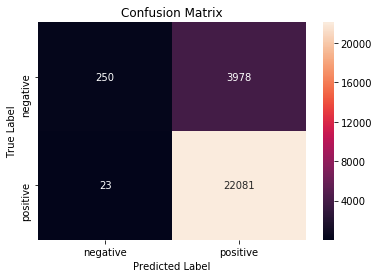

In [134]:
showHeatMap(con_mat)

Observation : My model misclassifed 23 + 3978 points

In [135]:
bow_featurennames = count_vect.get_feature_names()
print(bow_featurennames[100])

abruzzo


In [136]:
clf = MultinomialNB(alpha=10)
clf.fit(final_counts, y_1)
pred = clf.predict(final_test_count)


In [137]:
feat_count = clf.feature_count_
feat_count.shape

(2, 46446)

In [138]:
# Number of samples encountered for each class during fitting
clf.class_count_

array([ 9953., 51488.])

In [139]:
probs = clf.feature_log_prob_

In [140]:
feature_prob = pd.DataFrame(probs, columns = bow_featurennames)
feature_prob_tr = feature_prob.T
feature_prob_tr.shape

(46446, 2)

### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [141]:
print("\n\n Top 10 Positive Features:-\n",feature_prob_tr[1].sort_values(ascending = False)[0:10])



 Top 10 Positive Features:-
 not      -3.925894
like     -4.733360
good     -4.864065
great    -4.951355
one      -5.084318
taste    -5.172942
coffee   -5.206030
flavor   -5.275124
love     -5.281123
would    -5.282327
Name: 1, dtype: float64


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [142]:
print("Top 10 Negative Features:-\n",feature_prob_tr[0].sort_values(ascending = False)[0:10])

Top 10 Negative Features:-
 not       -3.999070
like      -5.118756
would     -5.353858
product   -5.389252
taste     -5.400513
one       -5.598615
coffee    -5.823486
good      -5.832546
flavor    -5.882702
no        -5.886297
Name: 0, dtype: float64


## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [143]:
X_1, X_test, y_1, y_test = cross_validation.train_test_split(preprocessed_reviews, final['Score'], test_size=0.3, random_state=0)

AUC: 0.771
AUC: 0.791
AUC: 0.818
AUC: 0.731
AUC: 0.890
AUC: 0.908
AUC: 0.735
AUC: 0.673
AUC: 0.635
AUC: 0.617
AUC: 0.614
#######################################################
AUC from train data ###################################
AUC: 0.989
AUC: 0.988
AUC: 0.988
AUC: 0.989
AUC: 0.985
AUC: 0.975
AUC: 0.745
AUC: 0.672
AUC: 0.631
AUC: 0.613
AUC: 0.610


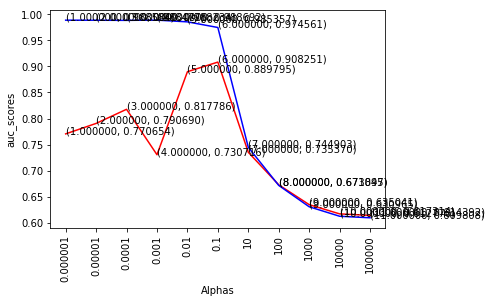

In [144]:
tf_idf_vect = TfidfVectorizer()
tf_idf_vect.fit(X_1)
final_tf_idf = tf_idf_vect.transform(X_1)
final_test_count = tf_idf_vect.transform(X_test)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

final_counts_tr_cv = tf_idf_vect.transform(X_tr)
final_test_count_cv = tf_idf_vect.transform(X_cv)

get_optimum_alpha(final_counts_tr_cv,final_test_count_cv,y_tr,y_cv)


The accuracy of the NB classifier for alpha = 10.000000 is 83.943491%
AUC: 0.748


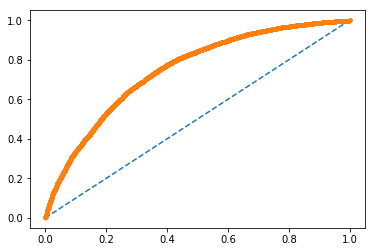

In [145]:
con_mat=nb_results(10,final_tf_idf,final_test_count,y_1,y_test)

Observation : With alpha = 10 the accuracy is 83 % and AUC is 0.748.

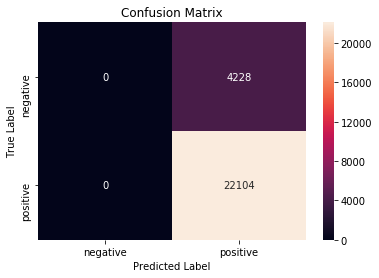

In [146]:
showHeatMap(con_mat)

Observation: My model pedicted 4228 points wrongly

In [147]:
tfidf_featurennames = tf_idf_vect.get_feature_names()

In [148]:
clf = MultinomialNB(alpha=10)
clf.fit(final_tf_idf, y_1)
pred = clf.predict(final_test_count)

In [149]:
feat_count = clf.feature_count_
feat_count.shape

(2, 46446)

In [150]:
clf.class_count_

array([ 9953., 51488.])

In [151]:
probs = clf.feature_log_prob_

In [152]:
feature_prob = pd.DataFrame(probs, columns = tfidf_featurennames)
feature_prob_tr = feature_prob.T
feature_prob_tr.shape

(46446, 2)

### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [153]:
print("\n\n Top 10 Positive Features:-\n",feature_prob_tr[1].sort_values(ascending = False)[0:10])



 Top 10 Positive Features:-
 not       -5.893515
great     -6.200917
good      -6.266220
coffee    -6.325771
like      -6.333298
love      -6.434347
tea       -6.456825
taste     -6.572348
one       -6.583339
product   -6.590492
Name: 1, dtype: float64


### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [154]:
print("Top 10 Negative Features:-\n",feature_prob_tr[0].sort_values(ascending = False)[0:10])

Top 10 Negative Features:-
 not       -6.613617
like      -7.405604
taste     -7.503258
product   -7.516003
would     -7.533082
coffee    -7.710883
one       -7.837948
flavor    -7.917743
no        -7.993194
good      -8.041537
Name: 0, dtype: float64


### repeat with extra features

In [179]:
mylen = np.vectorize(len)
newarr = mylen(preprocessed_summary)

In [180]:
newproce_reviews = np.asarray(preprocessed_reviews)

In [181]:
newproce_summary = np.asanyarray(preprocessed_summary)

In [182]:
df = pd.DataFrame({'desc':newproce_reviews, 'summary':newproce_summary,'len':newarr})

In [183]:
df.head()

,desc,summary,len
0,dogs loves chicken product china wont buying a...,made china,10
1,dogs love saw pet store tag attached regarding...,dog lover delites,17
2,infestation fruitflies literally everywhere fl...,one fruitfly stuck,18
3,worst product gotten long time would rate no s...,not work not waste money,24
4,wish would read reviews making purchase basica...,big rip,7


In [184]:
#df = df[:60000]
print(len(final['Score']))


87773


In [185]:
X_1, X_test, y_1, y_test = cross_validation.train_test_split(df, final['Score'], test_size=0.3, random_state=0)

(43008, 46447)
final_counts_tr_cv.shape after length =  (43008, 46447)
sujet (43008, 1)
final_counts_tr_cv.shape after f1=  (43008, 46448)
final_counts_tr_cv.shape after f2=  (43008, 46449)
AUC: 0.784
AUC: 0.804
AUC: 0.828
AUC: 0.740
AUC: 0.885
AUC: 0.906
AUC: 0.696
AUC: 0.529
AUC: 0.510
AUC: 0.502
AUC: 0.502
#######################################################
AUC from train data ###################################
AUC: 0.983
AUC: 0.983
AUC: 0.983
AUC: 0.984
AUC: 0.979
AUC: 0.971
AUC: 0.723
AUC: 0.533
AUC: 0.513
AUC: 0.503
AUC: 0.503


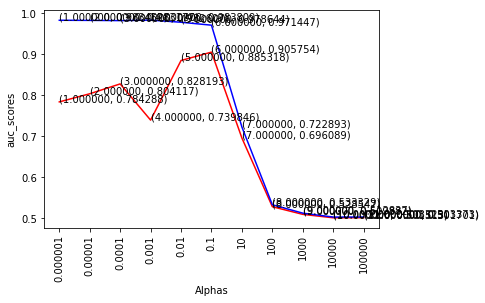

In [186]:
import scipy
count_vect = CountVectorizer()
final_counts = count_vect.fit_transform(X_1['desc'])
final_test_count = count_vect.transform(X_test['desc'])

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

final_counts_tr_cv = count_vect.transform(X_tr['desc'])
final_test_count_cv = count_vect.transform(X_cv['desc'])

from scipy.sparse import csr_matrix, issparse

##################Adding len as feature##########################
#if issparse(final_counts_tr_cv):
    #print('sparse matrix')
len_sparse = scipy.sparse.coo_matrix(X_tr['len'])
len_sparse = len_sparse.transpose()

final_counts_tr_cv = scipy.sparse.hstack([final_counts_tr_cv, len_sparse])
print(final_counts_tr_cv.shape)

len_test_sparse = scipy.sparse.coo_matrix(X_cv['len'])
len_test_sparse = len_test_sparse.transpose()
final_test_count_cv = scipy.sparse.hstack([final_test_count_cv,len_test_sparse])
print("final_counts_tr_cv.shape after length = ",final_counts_tr_cv.shape)

##################Adding summary as feature##########################
final_summary_count = count_vect.transform(X_tr['summary'])
final_test_summary_count_cv = count_vect.transform(X_cv['summary'])
columns=count_vect.get_feature_names()

print("sujet",final_summary_count[:,12].shape)


#df1 = pd.DataFrame(final_summary_count.toarray(), columns=count_vect.get_feature_names())
#print(df1['abandon'].shape)

#f1_sparse = scipy.sparse.coo_matrix(df1['abandon'])
#f1_sparse = f1_sparse.transpose()
final_counts_tr_cv = scipy.sparse.hstack([final_counts_tr_cv, final_summary_count[:,12]])
print("final_counts_tr_cv.shape after f1= ",final_counts_tr_cv.shape)


#df2 = pd.DataFrame(final_test_summary_count_cv.toarray(), columns=count_vect.get_feature_names())

#f1_test_sparse = scipy.sparse.coo_matrix(df2['abandon'])
#f1_test_sparse = f1_test_sparse.transpose()
final_test_count_cv = scipy.sparse.hstack([final_test_count_cv,final_test_summary_count_cv[:,12]])


#f1_sparse = scipy.sparse.coo_matrix(df1['zucchini'])
#f1_sparse = f1_sparse.transpose()
final_counts_tr_cv = scipy.sparse.hstack([final_counts_tr_cv, final_summary_count[:,112]])
print("final_counts_tr_cv.shape after f2= ",final_counts_tr_cv.shape)


#df2 = pd.DataFrame(final_test_summary_count_cv.toarray(), columns=count_vect.get_feature_names())

#f1_test_sparse = scipy.sparse.coo_matrix(df2['zucchini'])
#f1_test_sparse = f1_test_sparse.transpose()
final_test_count_cv = scipy.sparse.hstack([final_test_count_cv,final_test_summary_count_cv[:,112]])


get_optimum_alpha(final_counts_tr_cv,final_test_count_cv,y_tr,y_cv)

Initial final countes =  (61441, 46446)
final_test_count.shape after length =  (26332, 46447)
Initial final countes after length =  (61441, 46447)
final_test_count.shape after f1 =  (26332, 46448)
Initial final countes after f1 =  (61441, 46448)
final_test_count.shape after f2 =  (26332, 46449)
Initial final countes after f2 =  (61441, 46449)

The accuracy of the NB classifier for alpha = 10.000000 is 84.372626%
AUC: 0.745


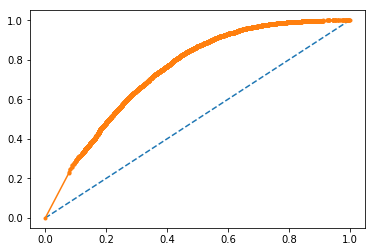

In [187]:
print("Initial final countes = ",final_counts.shape)

#############Adding length as a feature#################
train_sparse = scipy.sparse.coo_matrix(X_1['len'])
train_sparse = train_sparse.transpose()
final_counts = scipy.sparse.hstack([final_counts,train_sparse])

test_sparse = scipy.sparse.coo_matrix(X_test['len'])
test_sparse = test_sparse.transpose()
final_test_count = scipy.sparse.hstack([final_test_count,test_sparse])

print("final_test_count.shape after length = ",final_test_count.shape)
print("Initial final countes after length = ",final_counts.shape)

###############Adding summary feature as a feature#########################

final_summary = count_vect.transform(X_1['summary'])

#df3 = pd.DataFrame(final_summary.toarray(), columns=count_vect.get_feature_names())

#print(df1['abandon'].shape)

#f1_sparse = scipy.sparse.coo_matrix(df3['abandon'])
#f1_sparse = f1_sparse.transpose()
final_counts = scipy.sparse.hstack([final_counts, final_summary[:,12]])

final_test_summary = count_vect.transform(X_test['summary'])
#df4 = pd.DataFrame(final_test_summary.toarray(), columns=count_vect.get_feature_names())
#print(df1['abandon'].shape)

#f1_test_sparse = scipy.sparse.coo_matrix(df4['abandon'])
#f1_test_sparse = f1_test_sparse.transpose()
final_test_count = scipy.sparse.hstack([final_test_count, final_test_summary[:,12]])
print("final_test_count.shape after f1 = ",final_test_count.shape)
print("Initial final countes after f1 = ",final_counts.shape)


#f1_sparse = scipy.sparse.coo_matrix(df3['zucchini'])
#f1_sparse = f1_sparse.transpose()
final_counts = scipy.sparse.hstack([final_counts, final_summary[:,112]])


#final_test_summary = count_vect.transform(X_test['summary'])
#df4 = pd.DataFrame(final_test_summary.toarray(), columns=count_vect.get_feature_names())
#print(df1['abandon'].shape)

#f1_test_sparse = scipy.sparse.coo_matrix(df4['zucchini'])
#f1_test_sparse = f1_test_sparse.transpose()
final_test_count = scipy.sparse.hstack([final_test_count, final_test_summary[:,112]])
print("final_test_count.shape after f2 = ",final_test_count.shape)
print("Initial final countes after f2 = ",final_counts.shape)



con_mat=nb_results(10,final_counts,final_test_count,y_1,y_test)

Observation : With alpha = 10 the accuracy is 84 % and AUC is 0.745 which is much better than dumb model.

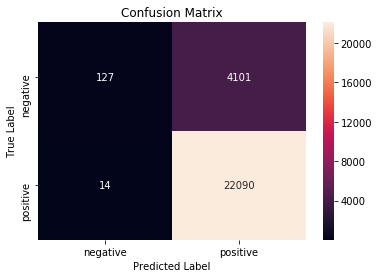

In [188]:
showHeatMap(con_mat)

Observation: My model pedicted 14 + 4101 points wrongly

In [198]:
X_1, X_test, y_1, y_test = cross_validation.train_test_split(df, final['Score'], test_size=0.3, random_state=0)

final_counts_tr_cv.shape after len=  (43008, 46447)
final_counts_tr_cv.shape after f1=  (43008, 46448)
final_counts_tr_cv.shape after f2=  (43008, 46449)
AUC: 0.762
AUC: 0.783
AUC: 0.811
AUC: 0.720
AUC: 0.885
AUC: 0.903
AUC: 0.548
AUC: 0.519
AUC: 0.514
AUC: 0.513
AUC: 0.512
#######################################################
AUC from train data ###################################
AUC: 0.989
AUC: 0.989
AUC: 0.988
AUC: 0.989
AUC: 0.985
AUC: 0.970
AUC: 0.547
AUC: 0.516
AUC: 0.511
AUC: 0.509
AUC: 0.508


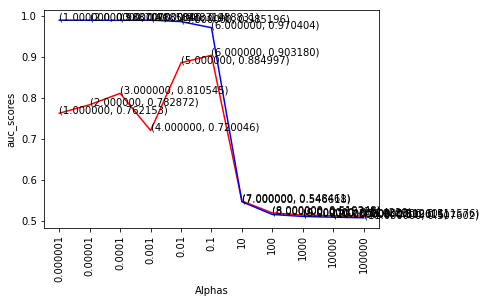

In [199]:
tf_idf_vect = TfidfVectorizer()
tf_idf_vect.fit(X_1['desc'])
final_tf_idf = tf_idf_vect.transform(X_1['desc'])
final_test_count = tf_idf_vect.transform(X_test['desc'])

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

final_counts_tr_cv = tf_idf_vect.transform(X_tr['desc'])
final_test_count_cv = tf_idf_vect.transform(X_cv['desc'])

##################Adding len as feature##########################
#if issparse(final_counts_tr_cv):
    #print('sparse matrix')
len_sparse = scipy.sparse.coo_matrix(X_tr['len'])
len_sparse = len_sparse.transpose()

final_counts_tr_cv = scipy.sparse.hstack([final_counts_tr_cv, len_sparse])

len_test_sparse = scipy.sparse.coo_matrix(X_cv['len'])
len_test_sparse = len_test_sparse.transpose()
final_test_count_cv = scipy.sparse.hstack([final_test_count_cv,len_test_sparse])
print("final_counts_tr_cv.shape after len= ",final_counts_tr_cv.shape)

##################Adding summary as feature##########################
final_summary_count = tf_idf_vect.transform(X_tr['summary'])
final_test_summary_count_cv = tf_idf_vect.transform(X_cv['summary'])
columns=tf_idf_vect.get_feature_names()


#df1 = pd.DataFrame(final_summary_count.toarray(), columns=tf_idf_vect.get_feature_names())
#print(df1['abandon'].shape)

#f1_sparse = scipy.sparse.coo_matrix(df1['abandon'])
#f1_sparse = f1_sparse.transpose()
final_counts_tr_cv = scipy.sparse.hstack([final_counts_tr_cv, final_summary_count[:,12]])
print("final_counts_tr_cv.shape after f1= ",final_counts_tr_cv.shape)


#df2 = pd.DataFrame(final_test_summary_count_cv.toarray(), columns=count_vect.get_feature_names())

#f1_test_sparse = scipy.sparse.coo_matrix(df2['abandon'])
#f1_test_sparse = f1_test_sparse.transpose()
final_test_count_cv = scipy.sparse.hstack([final_test_count_cv,final_test_summary_count_cv[:,12]])


#f1_sparse = scipy.sparse.coo_matrix(df1['zucchini'])
#f1_sparse = f1_sparse.transpose()
final_counts_tr_cv = scipy.sparse.hstack([final_counts_tr_cv, final_summary_count[:,112]])
print("final_counts_tr_cv.shape after f2= ",final_counts_tr_cv.shape)


#df2 = pd.DataFrame(final_test_summary_count_cv.toarray(), columns=count_vect.get_feature_names())

#f1_test_sparse = scipy.sparse.coo_matrix(df2['zucchini'])
#f1_test_sparse = f1_test_sparse.transpose()
final_test_count_cv = scipy.sparse.hstack([final_test_count_cv,final_test_summary_count_cv[:,112]])

get_optimum_alpha(final_counts_tr_cv,final_test_count_cv,y_tr,y_cv)

final_counts_tr_cv.shape =  (61441, 46448)
final_counts_tr_cv.shape =  (61441, 46449)
test.shape =  (26332, 46449)

The accuracy of the NB classifier for alpha = 10.000000 is 83.947288%
AUC: 0.550


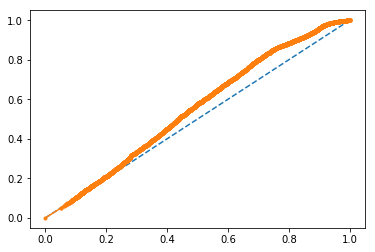

In [200]:
train_sparse = scipy.sparse.coo_matrix(X_1['len'])
train_sparse = train_sparse.transpose()
final_tf_idf = scipy.sparse.hstack([final_tf_idf,train_sparse])

test_sparse = scipy.sparse.coo_matrix(X_test['len'])
test_sparse = test_sparse.transpose()
final_test_count = scipy.sparse.hstack([final_test_count,test_sparse])

###############Adding summary feature as a feature#########################
final_summary = count_vect.transform(X_1['summary'])

#df3 = pd.DataFrame(final_summary.toarray(), columns=tf_idf_vect.get_feature_names())

#f1_sparse = scipy.sparse.coo_matrix(df3['abandon'])
#f1_sparse = f1_sparse.transpose()
final_tf_idf = scipy.sparse.hstack([final_tf_idf, final_summary[:,12]])
print("final_counts_tr_cv.shape = ",final_tf_idf.shape)

final_test_summary = count_vect.transform(X_test['summary'])
#df4 = pd.DataFrame(final_test_summary.toarray(), columns=tf_idf_vect.get_feature_names())

#f1_test_sparse = scipy.sparse.coo_matrix(df4['abandon'])
#f1_test_sparse = f1_test_sparse.transpose()
final_test_count = scipy.sparse.hstack([final_test_count, final_test_summary[:,12]])


#f1_sparse = scipy.sparse.coo_matrix(df3['zucchini'])
#f1_sparse = f1_sparse.transpose()
final_tf_idf = scipy.sparse.hstack([final_tf_idf, final_summary[:,112]])
print("final_counts_tr_cv.shape = ",final_tf_idf.shape)

#final_test_summary = count_vect.transform(X_test['summary'])
#df4 = pd.DataFrame(final_test_summary.toarray(), columns=tf_idf_vect.get_feature_names())

#f1_test_sparse = scipy.sparse.coo_matrix(df4['zucchini'])
#f1_test_sparse = f1_test_sparse.transpose()
final_test_count = scipy.sparse.hstack([final_test_count, final_test_summary[:,112]])
print("test.shape = ",final_test_count.shape)

con_mat=nb_results(10,final_tf_idf,final_test_count,y_1,y_test)

Observation : With alpha = 10 the accuracy is 84 % and AUC is 0.550.This model is not good.

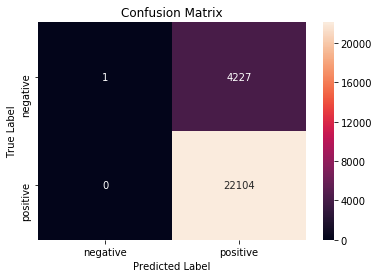

In [201]:
showHeatMap(con_mat)

Observation: My model pedicted 4227 points wrongly

# [6] Conclusions

| Method | No of samples |alpha | accuray | AUC Score |
| --- | --- | --- | --- | --- |
| BOW | 100000 | 10 | 84| 0.738 |
| TFIDF | 100000 | 10 | 83 | 0.748 |
| BOW1 | 100000 | 10 | 84| 0.745 |
| TFIDF1 | 100000 | 10 | 84 | 0.550 |
